# Read me
This template is meant to be a starter for your customized DREEM output data analysis.

- To install this library, please check the installation on the [Git repo](https://github.com/yvesmartindestaillades/NAP).
- To learn how to use this library, please get through the [tutorial](tutorial.ipynb).


# Turner overthrown

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns

from dreem_nap import data_wrangler, database, plot, utils
from dreem_nap.study import Study


# Step 1: Data wrangling
### Step 1.1: Define your study and some basics about your project

In [33]:
# Set your root folder for the database (at the moment, keep Yves)
folder = 'Yves'

# Select your study
study_name = 'temperature' 

## Set your base coverage high-pass filter value
min_bases_cov = 1000 

# Set the resolution for the plots
mpl.rcParams['figure.dpi'] = 200 # the highest the resolution, the slowest the plotting
mpl.rcParams["figure.figsize"] = [25, 10]
#plt.rcParams["figure.autolayout"] = True

# Depending on the study you select, you'll get a series of samples. You can also create new studies using this dictionary.
# Here's an example.
studies = data_wrangler.load_studies('../data/studies.csv')

study = studies.loc[study_name]
study

name                                                   temperature
description                             Try different temperatures
samples                           [D7, E7, F7, G7, H7, A8, B8, C8]
conditions_unit                                                 °C
conditions         [5.0, 10.0, 25.0, 45.0, 55.0, 65.0, 75.0, 90.0]
Name: temperature, dtype: object

### Step 1.2: Process new pickle files and push them to Firebase
- Select which samples you want to push to Firebase.
To plot automatically arrays of samples, see [tutorial](tutorial.ipynb), section 3.2.
- Process samples and push them to Firebase.

In [ ]:
## Pickle files to process and to push to Firebase
pickles_list = study.samples # Can be samples if you want to process the samples from your study

pickles = {pickle: f"../data/FULLSET/{pickle}/mutation_histos.p" for pickle in pickles_list}

# Indicate the location of your RNA structure file
RNAstructureFile = '../data/RNAstructureFile.csv'

# Default location for your local database (JSON file)
json_file = '../data/db.json'

# If the user gives some new pickles files, push them to the firebase, then pull the entire firebase
if len(pickles):
    data_wrangler.push_samples_to_firebase(pickles = pickles,
                        RNAstructureFile = RNAstructureFile,
                        min_bases_cov = min_bases_cov, 
                        folder=folder)

### Step 1.3: Pull the data from the Firebase and clean/reformat it.
`df` is used for the analysis. Each of the construct have above 1000 reads for each sample.     
`df_full` is used for quality quality analysis. It has all constructs above 1000 valid reads for each sample individually.

In [ ]:
# Pull the firebase
df_database = database.load(study=study, folder=folder)

#data_wrangler.dump_dict_json(JSONFileDict=json_file, df=df_database)
#df_database = data_wrangler.json_load(json_file)

# Clean and reformat the dataset
df, df_full = data_wrangler.clean_dataset(df_database=df_database,
                                             study=study)
print(f"{df.groupby('construct')['samples_covered'].count().count()} constructs have more than {min_bases_cov} reads for each base of their ROI on each sample")
        

# Step 2: Data quality analysis

It's always hard to realize that you were analysing noise. Here, we'll get through a series a plot to check the data sanity.

### Get the list of samples and constructs:

In [ ]:
print(f"samples are: {study.samples}")
print(f"constructs are: {df.construct.unique()}")

### Explore the data
`get_roi_info(df=df, sample=sample, construct=construct)` gives information about the Region of Interest (ROI) of a (sample, construct) pair.

In [ ]:
samp, construct = utils.rand_sample_construct(df)

utils.get_roi_info(df=df, samp=samp, construct=construct)#.xs((True, '0'),level=('paired','roi_structure_comparison'))   

### (sample, construct)-specific base coverage plot

In [ ]:
samp, construct = utils.rand_sample_construct(df)
plot.base_coverage(df, samp, construct)

### Plot the base coverage per construct distribution

In [ ]:
plot.base_coverage_ROI_for_all_constructs(df=df_full)

### Sanity-check construct-wise base coverage plots
Plot randomly picked sequences to check the quality of the data.

In [ ]:
plot.random_9_base_coverage(df=df)

### Heatmap of the roi part coverage

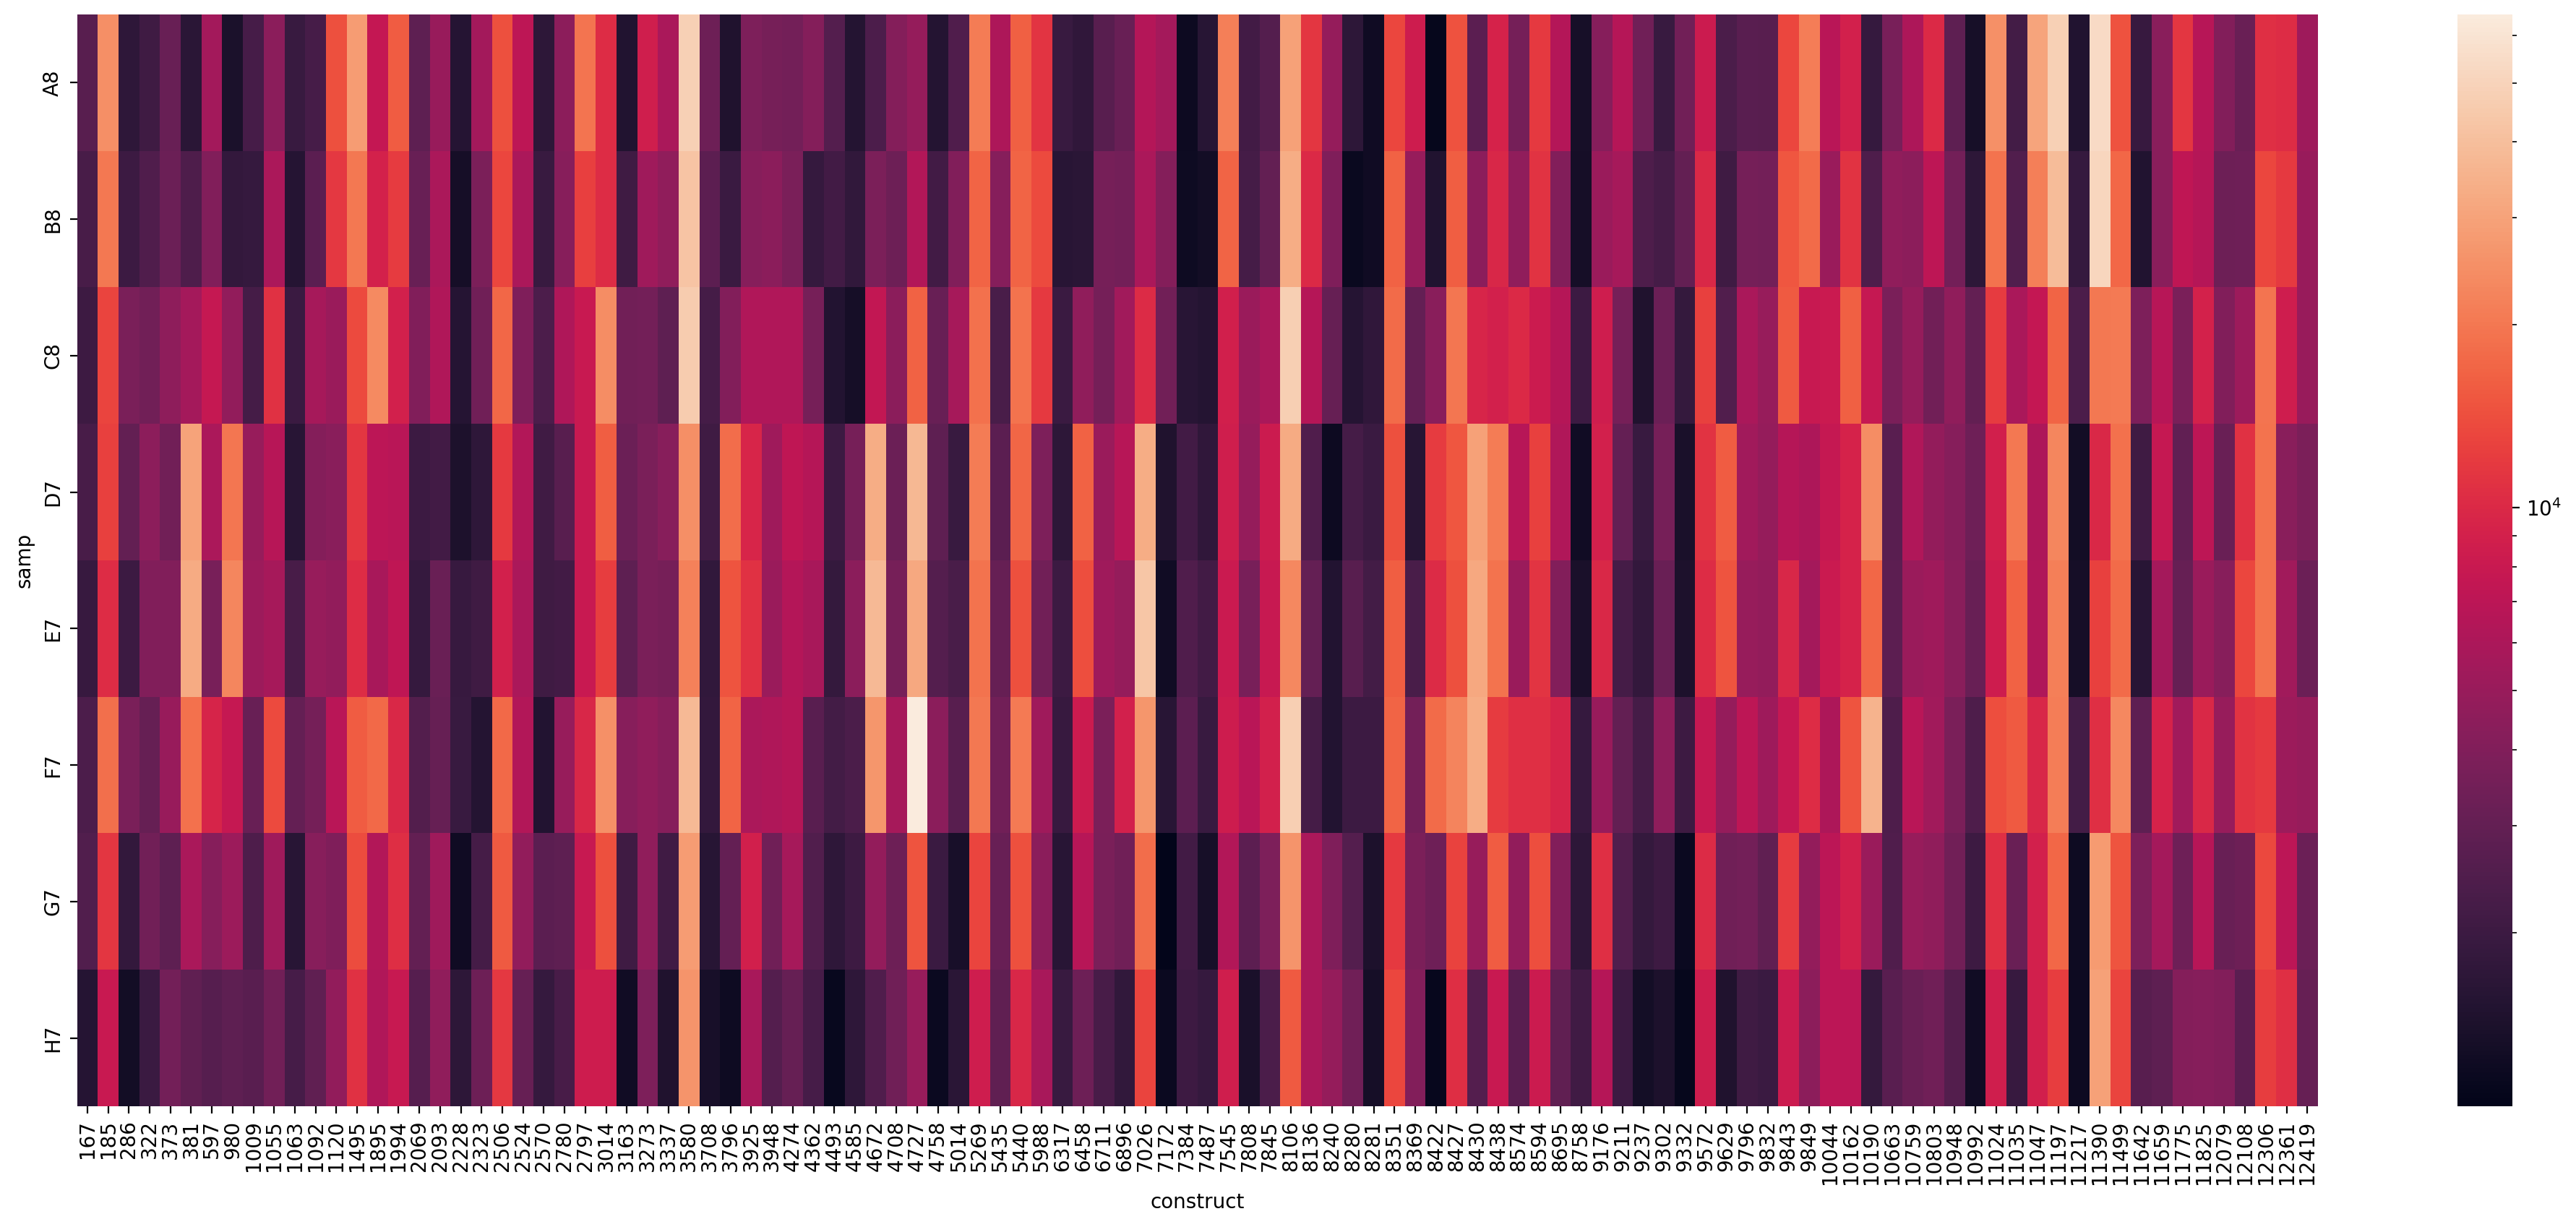

In [35]:
plot.heatmap(df = df, 
             column="cov_bases_roi")

### Heatmap of the second half coverage

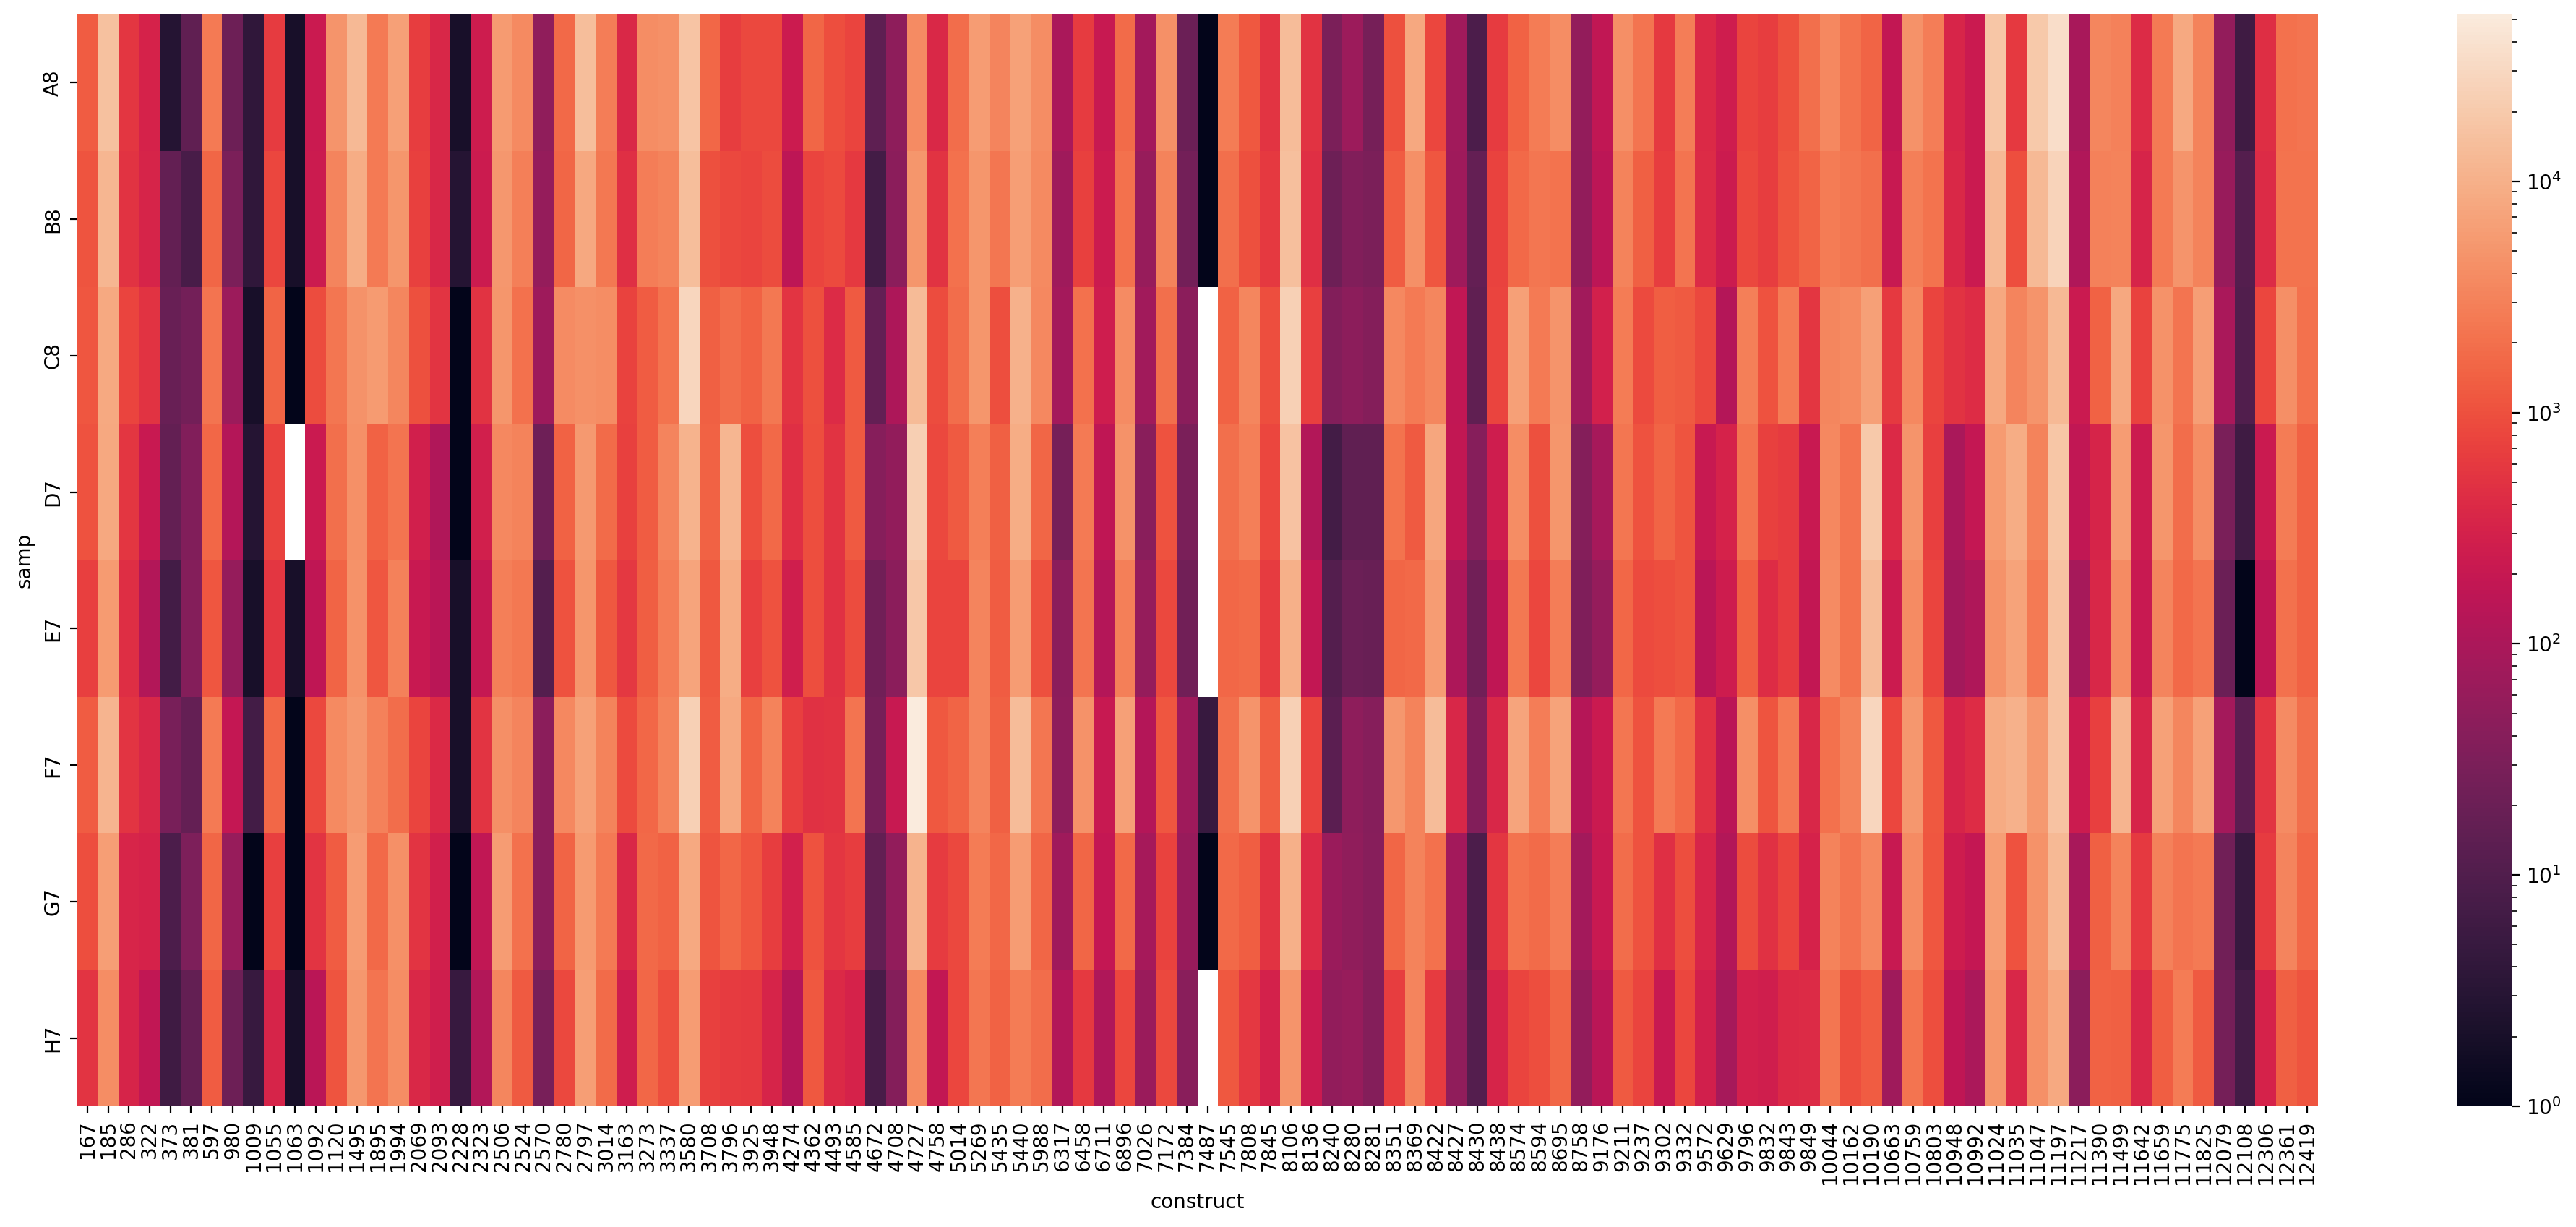

In [36]:
plot.heatmap(df = df, 
                column="cov_bases_sec_half")

# Step 3: Data analysis
In this part, we know that we read good data, and we want to visualize it through different plots.

### Analysis parameters

In [37]:
# Display the plots on this notebook? Not recommended if numerous plots
show_plots = True

# Constructs used
a_few_constructs = df.construct.unique()[:3].tolist()
first_construct = df.construct.unique()[0].tolist()
constructs_per_name = {
    'all_constructs': df.construct.unique().tolist(),
    str(a_few_constructs) : a_few_constructs,
    str(first_construct): [first_construct]
}

# Select constructs here
constructs_name = str(a_few_constructs)

# Define what you will analyse
constructs = constructs_per_name[constructs_name]

### Big script to run every selected function

In [38]:
# Analysis run in this script
analysis = {'base_per_base_partition':False,
            'base_per_base_sequence': True,
            'deltaG': True,
            'sample_comparison':False,
            'columns_csv': True,
            'deltaG_construct': True
            }

# Write here a script to get your plots 

### Mutation sequence-wise

`plot.mutation_rate(df, sample, construct, plot_type, index, normalize)` plots the mutation rate base-wise for a given construct of a given sample as a barplot. 
Arguments:
- `plot_type` :
    - `'sequence'` : each bar is colored w.r.t to the base of the original sequence.
    - `'partition'` : each bar shows the partition of into which bases this base mutates.
- `index`:
    - `'index'`: each base is identified with its position number
    - `'base'`: each base is identified with its type (A, C, G, T)

In [ ]:
for construct in constructs:
    for samp in study.samples:
        plot.mutation_rate(df=df,
                           sample=samp,
                           construct=construct,
                           plot_type='sequence',
                           index='index')
        utils.save_fig(path=f"data/figs/date/{study}/mut_per_base/sequence/{construct}/", 
                    title=f"base_per_base_sequence_{samp}_{construct}")
        plt.close(not show_plots)

### DeltaG plots

In [ ]:
for samp in study.samples:
    plot.deltaG(df=df, sample=samp)

    utils.save_fig(path=f"data/figs/date/{study}/deltaG/", 
             title=f"deltaG_{samp}")

    plt.close(not show_plots)

### samples correlation

In [ ]:
for construct in [constructs[0]]:
        df_global_corr = plot.correlation_n_samples(df, study, construct)
        utils.save_fig(path=f"data/figs/date/correlation/{study}", 
                      title=f"correlation_{study}_{construct}")
        plt.title(f"Study: {study}")
        plt.close(not show_plots)
        print(construct, end=' ')

In [ ]:
show_plots = False
for study in studies:
    samples = study['samples']
    for constructs in df.construct.unique():
        constructs_name = constructs
        df_global_corr = plot.correlation_n_samples(df, samples, constructs)
        plt.title(f"Correlation between samples for study: {study}, constructs: {constructs_name}")
        utils.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                        title=f"correlation_fit_{study}_{constructs_name}")
        plt.close(not show_plots)

        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
            plt.title(f"{plt_type} of the correlation between samples for study: {study}, constructs: {constructs_name}")
            utils.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                            title=f"correlation_{plt_type}_{study}_{constructs_name}")
            plt.close(not show_plots)

### Heat Map

In [ ]:
#pivot = df_global_corr.pivot("sample_0","sample_1", 'r_value').astype(float)
df_global_corr

In [ ]:
for plt_type in ['r_value', 'slope']:
    pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
    f, ax = plt.subplots(figsize=(28, 10))
    sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
    plt.title(plt_type)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{plt_type}_{study}_all_constructs")
   # plt.close(not show_plots)

### Global correlation plot

In [ ]:
heat_map = True

for study in studies:
    samples = study['samples']
    df_global_corr = plot.correlation_n_samples(df, samples, constructs)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

    if heat_map:
        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax, norm=LogNorm())
            utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                            title=f"correlation_{plt_type}_{study}_all_constructs")
            plt.close(not show_plots)

In [ ]:
show_plots = 1
for study in studies:
    samples = studies[study]['samples']
    if study == 'all_samples': continue
    plot.correlation_n_samples(df, samples, constructs)
    plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

### Temperature vs reactivity plots

In [ ]:
plot.mut_rate_along_study(df, samples, study)

### Save columns to a csv file

In [ ]:
utils.columns_to_csv(df=df,
                   samples=samples,
                   columns=['sample', 'construct','full_sequence','roi_sequence','mut_bases','info_bases'],
                   title=f"seq_and_reactivity_{study}",
                   path='data/figs/date/{study}')

### Save construct vs deltaG 

In [ ]:
utils.deltaG_vs_construct_to_csv(df=df,    
                                 title=f"deltaG_vs_construct.csv", 
                                 path = f"data/figs/date/{study}", 
                                 samples=samples)